In [32]:
# %%
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [34]:
# %%
# Define transforms: resize images to 64x64 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Change this to your dataset directory (each folder corresponds to one class)
data_dir = "./data/dataset"  
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Found classes:", dataset.classes)

# Get all indices and corresponding labels (ImageFolder stores labels in 'targets')
all_indices = np.arange(len(dataset))
all_labels = np.array(dataset.targets)

# First, split into train+val (80%) and test (20%) using stratification
trainval_idx, test_idx = train_test_split(all_indices, test_size=0.2, stratify=all_labels, random_state=42)

# Then split train+val into train (90%) and validation (10%) using stratification
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.1, stratify=all_labels[trainval_idx], random_state=42)

print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_idx)}")
print(f"Validation images: {len(val_idx)}")
print(f"Test images: {len(test_idx)}")

# Debug: Check distribution of training labels
from collections import Counter
print("Training label distribution:", Counter(all_labels[train_idx]))

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Found classes: ['circles', 'hexagons', 'pentagons', 'quatrefoil', 'spikes', 'squares', 'triangles']
Total images: 2100
Training images: 1512
Validation images: 168
Test images: 420
Training label distribution: Counter({1: 216, 0: 216, 4: 216, 2: 216, 6: 216, 3: 216, 5: 216})


In [35]:
# %%
# For KMeans clustering, we use the entire dataset (ignoring splits) since labels are used only for evaluation.
all_X = []
all_y = []
for img, label in dataset:
    all_X.append(img.view(-1).numpy())  # flatten the image
    all_y.append(label)
all_X = np.array(all_X)
all_y = np.array(all_y)
print("Data shape (samples x features):", all_X.shape)

Data shape (samples x features): (2100, 12288)


In [36]:
# %%
# Perform k-means clustering on the flattened image data.
n_clusters = 7  # expected number of clusters (can be adjusted)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_X)

In [37]:
# %%
def map_cluster_labels(y_true, y_pred):
    """
    Map cluster labels to true labels using the Hungarian algorithm.
    """
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    new_preds = np.array([mapping[label] for label in y_pred])
    return new_preds, mapping

mapped_preds, mapping = map_cluster_labels(all_y, cluster_labels)

# Evaluate clustering performance
kmeans_acc = accuracy_score(all_y, mapped_preds) * 100
kmeans_f1  = f1_score(all_y, mapped_preds, average='macro')
print(f"KMeans Clustering Accuracy: {kmeans_acc:.2f}%")
print(f"KMeans Clustering F1 Score: {kmeans_f1:.4f}")

KMeans Clustering Accuracy: 21.10%
KMeans Clustering F1 Score: 0.1997


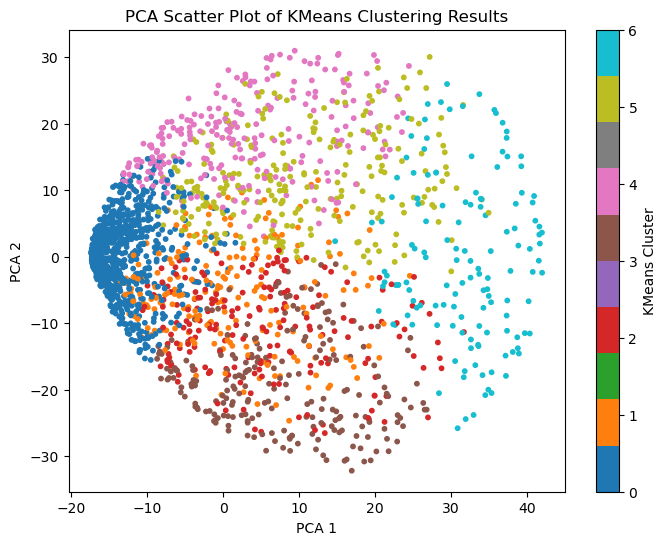

In [38]:
# %%
# Reduce data dimensionality to 2D using PCA for visualization.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("PCA Scatter Plot of KMeans Clustering Results")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
cbar = plt.colorbar(ticks=range(n_clusters))
cbar.set_label("KMeans Cluster")
plt.show()

In [40]:
# %%
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Autoencoder, self).__init__()
        # Encoder: convolutional layers -> flatten -> linear layer.
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # -> (16, 32, 32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*8*8, latent_dim)
        )
        # Decoder: linear layer -> reshape -> conv-transpose layers.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (3, 64, 64)
            nn.Sigmoid()  # output pixel values in [0,1]
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    
    def get_latent(self, x):
        return self.encoder(x)

# Instantiate the autoencoder and move it to the device
latent_dim = 32
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)


In [56]:
# %%
# Train the autoencoder using MSE loss and the Adam optimizer.
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()
n_epochs_ae = 100

train_losses = []
val_losses = []

for epoch in range(n_epochs_ae):
    autoencoder.train()
    running_train_loss = 0.0
    for imgs, _ in train_loader:  # Labels are not used.
        imgs = imgs.to(device)
        ae_optimizer.zero_grad()
        reconstructed = autoencoder(imgs)
        loss = criterion(reconstructed, imgs)
        loss.backward()
        ae_optimizer.step()
        running_train_loss += loss.item() * imgs.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation step
    autoencoder.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            reconstructed = autoencoder(imgs)
            loss = criterion(reconstructed, imgs)
            running_val_loss += loss.item() * imgs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{n_epochs_ae}] - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")


Epoch [1/100] - Train Loss: 0.0103 | Val Loss: 0.0114
Epoch [2/100] - Train Loss: 0.0089 | Val Loss: 0.0112
Epoch [3/100] - Train Loss: 0.0087 | Val Loss: 0.0112
Epoch [4/100] - Train Loss: 0.0086 | Val Loss: 0.0110
Epoch [5/100] - Train Loss: 0.0086 | Val Loss: 0.0111
Epoch [6/100] - Train Loss: 0.0085 | Val Loss: 0.0110
Epoch [7/100] - Train Loss: 0.0084 | Val Loss: 0.0110
Epoch [8/100] - Train Loss: 0.0082 | Val Loss: 0.0108
Epoch [9/100] - Train Loss: 0.0082 | Val Loss: 0.0109
Epoch [10/100] - Train Loss: 0.0081 | Val Loss: 0.0107
Epoch [11/100] - Train Loss: 0.0080 | Val Loss: 0.0110
Epoch [12/100] - Train Loss: 0.0078 | Val Loss: 0.0104
Epoch [13/100] - Train Loss: 0.0075 | Val Loss: 0.0107
Epoch [14/100] - Train Loss: 0.0078 | Val Loss: 0.0109
Epoch [15/100] - Train Loss: 0.0075 | Val Loss: 0.0104
Epoch [16/100] - Train Loss: 0.0074 | Val Loss: 0.0106
Epoch [17/100] - Train Loss: 0.0073 | Val Loss: 0.0109
Epoch [18/100] - Train Loss: 0.0075 | Val Loss: 0.0105
Epoch [19/100] - Tr

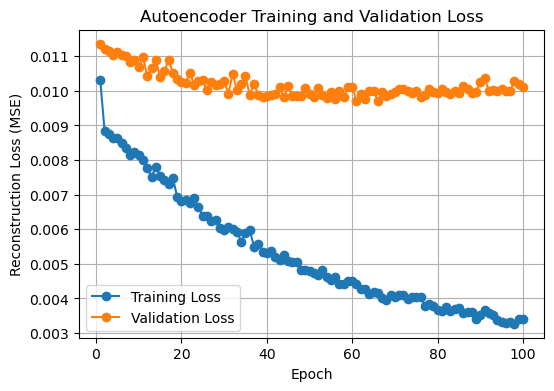

In [57]:
# %%
plt.figure(figsize=(6,4))
epochs = np.arange(1, n_epochs_ae+1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Autoencoder Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# %%
# Extract latent features from the training set
autoencoder.eval()
train_latents = []
train_labels_list = []
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        latent_features = autoencoder.get_latent(imgs)
        train_latents.append(latent_features.cpu().numpy())
        train_labels_list.extend(labels.numpy())
train_latents = np.concatenate(train_latents, axis=0)
train_labels_arr = np.array(train_labels_list)
print("Train latent features shape:", train_latents.shape)

# %%
# Extract latent features from the test set
test_latents = []
test_labels_list = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        latent_features = autoencoder.get_latent(imgs)
        test_latents.append(latent_features.cpu().numpy())
        test_labels_list.extend(labels.numpy())
test_latents = np.concatenate(test_latents, axis=0)
test_labels_arr = np.array(test_labels_list)
print("Test latent features shape:", test_latents.shape)


Train latent features shape: (1512, 32)
Test latent features shape: (420, 32)


In [59]:
# %%
# Train a logistic regression classifier on the latent features.
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(train_latents, train_labels_arr)
lr_preds = lr_clf.predict(test_latents)
lr_acc = accuracy_score(test_labels_arr, lr_preds) * 100
lr_f1  = f1_score(test_labels_arr, lr_preds, average='macro')
print(f"Logistic Regression on Latent Features - Accuracy: {lr_acc:.2f}% | F1: {lr_f1:.4f}")

Logistic Regression on Latent Features - Accuracy: 25.71% | F1: 0.2439


In [60]:
# %%
# Train a Random Forest classifier on the latent features.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(train_latents, train_labels_arr)
rf_preds = rf_clf.predict(test_latents)
rf_acc = accuracy_score(test_labels_arr, rf_preds) * 100
rf_f1  = f1_score(test_labels_arr, rf_preds, average='macro')
print(f"Random Forest on Latent Features - Accuracy: {rf_acc:.2f}% | F1: {rf_f1:.4f}")

Random Forest on Latent Features - Accuracy: 36.90% | F1: 0.3649


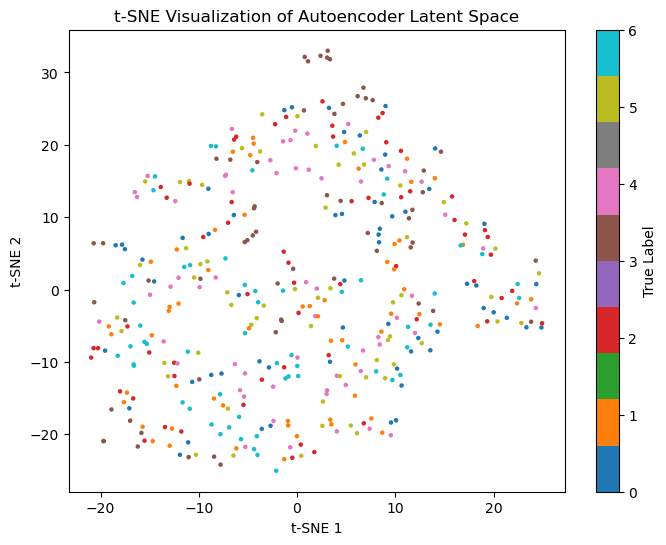

In [61]:
# %%
# Visualize the latent space using t-SNE (colored by true labels)
tsne_latents = TSNE(n_components=2, random_state=42).fit_transform(test_latents)
plt.figure(figsize=(8,6))
plt.scatter(tsne_latents[:, 0], tsne_latents[:, 1], c=test_labels_arr, cmap="tab10", s=5)
plt.title("t-SNE Visualization of Autoencoder Latent Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="True Label")
plt.show()

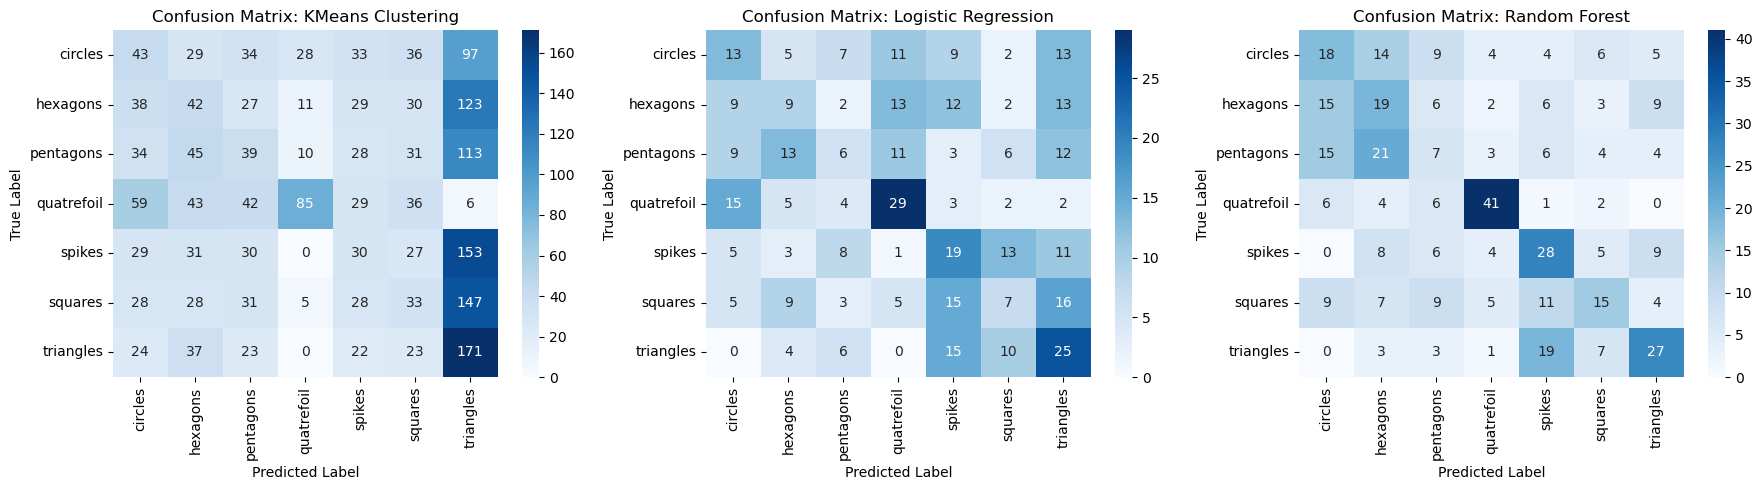

In [63]:
# %%
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix for KMeans clustering (using the entire dataset)
cm_kmeans = confusion_matrix(all_y, mapped_preds)

# Confusion matrix for Logistic Regression on test set
cm_lr = confusion_matrix(test_labels_arr, lr_preds)

# Confusion matrix for Random Forest on test set
cm_rf = confusion_matrix(test_labels_arr, rf_preds)

plt.figure(figsize=(18, 5))

# Plot for KMeans Clustering
plt.subplot(1, 3, 1)
sns.heatmap(cm_kmeans, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix: KMeans Clustering")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot for Logistic Regression
plt.subplot(1, 3, 2)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot for Random Forest
plt.subplot(1, 3, 3)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix: Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()
